In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
kospi = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kospi_data.csv', parse_dates = ['Date'])
sp500 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/S&P500.csv', parse_dates = ['날짜'], thousands = ",")

In [ ]:
df = kospi.drop(['High', 'Low', 'Volume','Open'], axis =1)
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df = df[df['year'] != 1981].reset_index(drop=True)       #1981년 제거
df['log'] = np.log(df['Close'] / df['Close'].shift(1))
df['log'][0] = df['Change'][0]
tb = df.pivot_table(index = 'year', columns = 'month', values = 'log', aggfunc ='sum').drop(2022) #2022년 제거

<ipython-input-3-988a7d04bd59>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log'][0] = df['Change'][0]


In [ ]:
df

,Date,Close,Change,year,month,log
0,1982-01-04,123.60,-0.0586,1982,1,-0.058600
1,1982-01-05,121.66,-0.0157,1982,1,-0.015820
2,1982-01-06,125.80,0.0340,1982,1,0.033463
3,1982-01-07,126.66,0.0068,1982,1,0.006813
4,1982-01-08,126.74,0.0006,1982,1,0.000631
...,...,...,...,...,...,...
10824,2022-08-25,2477.26,0.0122,2022,8,0.012106
10825,2022-08-26,2481.03,0.0015,2022,8,0.001521
10826,2022-08-29,2426.89,-0.0218,2022,8,-0.022063
10827,2022-08-30,2450.93,0.0099,2022,8,0.009857


In [ ]:
grp_df = df.groupby(['year', 'month'])['log'].sum().reset_index()
grp_df['lag_11'] = 0
for i in range(0, len(grp_df)):
  grp_df['lag_11'].iloc[i] = grp_df['log'][i+1:i+12].sum()
grp_df = grp_df.drop(range(len(grp_df)-11,len(grp_df)))   #마지막 11개 행 삭제
grp_df.describe()

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,year,month,log,lag_11
count,477.000000,477.000000,477.000000,477.000000
mean,2001.377358,6.471698,0.006611,0.071039
std,11.487304,3.447343,0.073195,0.276152
min,1982.000000,1.000000,-0.318104,-0.891025
25%,1991.000000,3.000000,-0.031712,-0.069282
50%,2001.000000,6.000000,0.006421,0.041052
75%,2011.000000,9.000000,0.042852,0.243722
max,2021.000000,12.000000,0.410616,1.139919


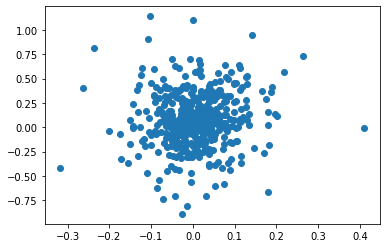

In [ ]:
plt.scatter(grp_df['log'], grp_df['lag_11'])
plt.show()

In [ ]:
def pt_R(R):
  f = pd.DataFrame(index = np.arange(1,13), columns = ['상관계수', '유의성', '변동성 상위 %d percent 상관계수' %R, '유의성'])
  for i in range(1,13):
    k = grp_df.loc[grp_df['month'] == i].reset_index(drop=True)
    kx = k.loc[abs(k['log'])>=np.percentile(abs(k['log']), 100 - R)]
    a = np.corrcoef(k['log'], k['lag_11'])[0,1]
    b = bool(stats.pearsonr(k['log'], k['lag_11'])[1] < 0.05)
    c = np.corrcoef(kx['log'], kx['lag_11'])[0,1]
    d = bool(stats.pearsonr(kx['log'], kx['lag_11'])[1] < 0.05)
    f.loc[i] = [a,b,c,d]
  print(f)

#변동성 상위 n%를 추출할 때 표준편차 등을 고려하여 기준을 세우고 싶었으나 정규성을 만족하지 못하여 실패..

In [ ]:
pt_R(50)

        상관계수    유의성 변동성 상위 50 percent 상관계수    유의성
1   0.149925  False               0.241894  False
2  -0.053334  False              -0.024236  False
3  -0.011925  False              -0.154162  False
4   0.040076  False               0.103915  False
5  -0.100306  False              -0.170119  False
6   -0.01593  False              -0.041187  False
7   0.209683  False               0.154601  False
8  -0.116755  False              -0.111501  False
9   0.012447  False              -0.066133  False
10  0.253494  False                0.30497  False
11  0.190635  False               0.211455  False
12  0.337892   True               0.489975   True


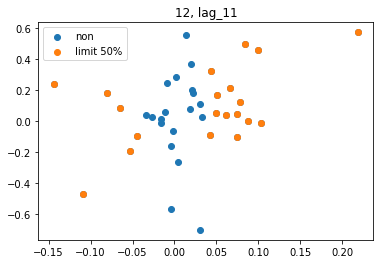

In [ ]:
k = grp_df.loc[grp_df['month'] == 12].reset_index(drop=True)
plt.scatter(k['log'], k['lag_11'], label = 'non')
kx = k.loc[abs(k['log'])>=np.percentile(abs(k['log']), 50)]
plt.scatter(kx['log'], kx['lag_11'], label = 'limit 50%')
plt.title('12, lag_11')
plt.legend()
plt.show()

In [ ]:
rate = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/rate.csv', parse_dates = ['변환'])
rate.columns = ['date', 'rate']
rate['rate'] = rate['rate']/100 * (11/12) # %변환 및 11개월 반영
rate['year'] = rate['date'].dt.year
rate['month'] = rate['date'].dt.month

In [ ]:
rate

,date,rate,year,month
0,2000-02-01,0.078192,2000,2
1,2000-03-01,0.076542,2000,3
2,2000-04-01,0.076450,2000,4
3,2000-05-01,0.076450,2000,5
4,2000-06-01,0.075533,2000,6
...,...,...,...,...
270,2022-08-01,0.027381,2022,8
271,2022-09-01,0.030131,2022,9
272,2022-10-01,0.033018,2022,10
273,2022-11-01,0.035182,2022,11


In [ ]:
new = pd.merge(grp_df, rate, left_on = ['year', 'month'], right_on = ['year', 'month'], how = 'inner').drop('date', axis =1) #국채금리 자료부족..
new['updown'] = 0
for i in range(0, len(new)):
  if new['lag_11'].iloc[i] > new['rate'].iloc[i]:
    new['updown'].iloc[i] = 1
  else:
    new['updown'].iloc[i] = -1
new['indi'] = new['log'] * new['updown']
new['indi'] = np.ceil(new['indi'])

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
new

,year,month,log,lag_11,rate,updown,indi
0,2000,2,-0.130527,-0.293129,0.078192,-1,1.0
1,2000,3,0.038553,-0.398278,0.076542,-1,-0.0
2,2000,4,-0.171315,-0.326707,0.076450,-1,1.0
3,2000,5,0.008907,-0.237151,0.076450,-1,-0.0
4,2000,6,0.115174,-0.293797,0.075533,-1,-0.0
...,...,...,...,...,...,...,...
255,2021,5,0.017652,-0.172958,0.005601,-1,-0.0
256,2021,6,0.028541,-0.204900,0.007315,-1,-0.0
257,2021,7,-0.029040,-0.316875,0.008342,-1,1.0
258,2021,8,-0.000953,-0.266223,0.009176,-1,1.0


In [ ]:
stats.ttest_1samp(new['indi'],0.5)

Ttest_1sampResult(statistic=0.6194382162118393, pvalue=0.5361722251474946)

In [ ]:
for i in range(1,13):
  print(i, '월 p.value는', stats.ttest_1samp(new.loc[new['month'] == i]['indi'], 0.5)[1])

1 월 p.value는 0.28596363317570905
2 월 p.value는 0.6799528986653569
3 월 p.value는 0.6799528986653569
4 월 p.value는 1.0
5 월 p.value는 0.40637117235267894
6 월 p.value는 0.6799528986653572
7 월 p.value는 0.20801346649528196
8 월 p.value는 0.40637117235267894
9 월 p.value는 0.6799528986653572
10 월 p.value는 0.28596363317570905
11 월 p.value는 0.28596363317570905
12 월 p.value는 0.8333286370363984


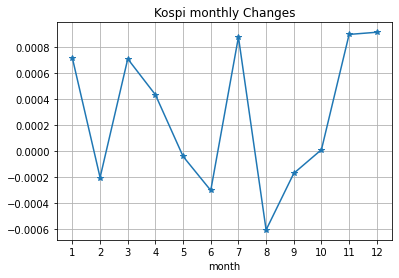

In [ ]:
df.groupby('month').mean()['log'].plot(marker='*')
plt.grid(True)
plt.xticks(np.arange(1,13,1))
plt.title('Kospi monthly Changes')
plt.show()

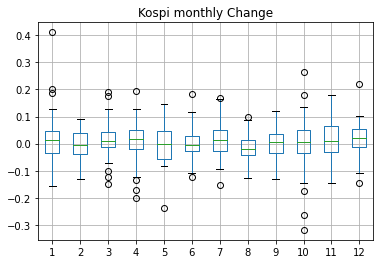

In [ ]:
tb.boxplot()
plt.title('Kospi monthly Change')
plt.show()

In [ ]:
df2 = sp500.drop(['Unnamed: 0', '오픈', '고가', '저가','거래량'], axis=1)
df2.columns = ['Date', 'Close', 'Change']
df2['year'] = df2['Date'].dt.year
df2['month'] = df2['Date'].dt.month
df2 = df2[df2['year'] != 1979].reset_index(drop=True)       #1979년 제거
df2 = df2[df2['year'] != 2023]
df2['log'] = np.log(df2['Close'] / df2['Close'].shift(1))
tb2 = df2.pivot_table(index = 'year', columns = 'month', values = 'log', aggfunc ='sum')

In [ ]:
grp_df2 = df2.groupby(['year', 'month'])['log'].sum().reset_index()
grp_df2['lag_11'] = 0
for i in range(0, len(grp_df2)):
  grp_df2['lag_11'].iloc[i] = grp_df2['log'][i+1:i+12].sum()
grp_df2 = grp_df2.drop(range(len(grp_df2)-11,len(grp_df2)))   #마지막 11개 행 삭제
grp_df2.describe()

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,year,month,log,lag_11
count,505.000000,505.000000,505.000000,505.000000
mean,2000.542574,6.489109,0.007394,0.076967
std,12.158619,3.460718,0.043793,0.151472
min,1980.000000,1.000000,-0.245295,-0.587437
25%,1990.000000,3.000000,-0.016497,0.013231
50%,2001.000000,6.000000,0.011510,0.098313
75%,2011.000000,9.000000,0.035100,0.169757
max,2022.000000,12.000000,0.123729,0.450796


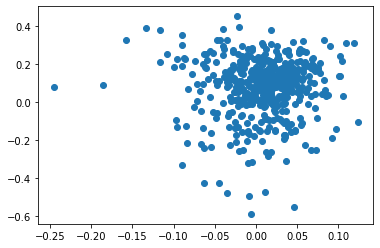

In [ ]:
plt.scatter(grp_df2['log'], grp_df2['lag_11'])
plt.show()

In [ ]:
grp_df2

,year,month,log,lag_11
0,1980,1,0.056746,0.173232
1,1980,2,-0.004388,0.130889
2,1980,3,-0.107611,0.251532
3,1980,4,0.040313,0.246390
4,1980,5,0.045065,0.177514
...,...,...,...,...
500,2021,9,-0.048738,-0.085386
501,2021,10,0.066858,-0.250294
502,2021,11,-0.008369,-0.165091
503,2021,12,0.042689,-0.155421


In [ ]:
def pt_R2(R):
  f = pd.DataFrame(index = np.arange(1,13), columns = ['상관계수', '유의성', '변동성 상위 %d percent 상관계수' %R, '유의성'])
  for i in range(1,13):
    k = grp_df2.loc[grp_df2['month'] == i].reset_index(drop=True)
    kx = k.loc[abs(k['log'])>=np.percentile(abs(k['log']), 100 - R)]
    a = np.corrcoef(k['log'], k['lag_11'])[0,1]
    b = bool(stats.pearsonr(k['log'], k['lag_11'])[1] < 0.05)
    c = np.corrcoef(kx['log'], kx['lag_11'])[0,1]
    d = bool(stats.pearsonr(kx['log'], kx['lag_11'])[1] < 0.05)
    f.loc[i] = [a,b,c,d]  
  print(f)


In [ ]:
pt_R2(40)

        상관계수    유의성 변동성 상위 40 percent 상관계수    유의성
1   0.157741  False               0.285696  False
2   0.006548  False              -0.037355  False
3  -0.221429  False              -0.381709  False
4   0.271181  False               0.514025   True
5   0.010874  False              -0.164288  False
6   0.170521  False               0.212208  False
7  -0.006137  False              -0.296235  False
8  -0.102698  False              -0.054576  False
9   0.048928  False               0.090274  False
10  0.006205  False               0.030807  False
11  0.124687  False               0.157032  False
12 -0.077232  False              -0.286303  False


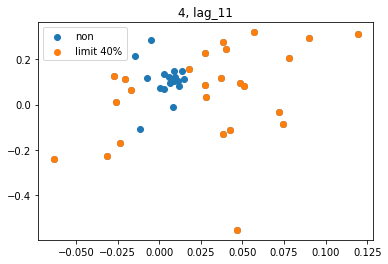

In [ ]:
k = grp_df2.loc[grp_df2['month'] == 4].reset_index(drop=True)
plt.scatter(k['log'], k['lag_11'], label = 'non')
kx = k.loc[abs(k['log'])>=np.percentile(abs(k['log']), 40)]
plt.scatter(kx['log'], kx['lag_11'], label = 'limit 40%')
plt.title('4, lag_11')
plt.legend()
plt.show()

In [ ]:
new2 = pd.merge(grp_df2, rate, left_on = ['year', 'month'], right_on = ['year', 'month'], how = 'inner').drop('date', axis =1) #국채금리 자료부족..
new2['updown'] = 0
for i in range(0, len(new2)):
  if new2['lag_11'].iloc[i] > new2['rate'].iloc[i]:
    new2['updown'].iloc[i] = 1
  else:
    new2['updown'].iloc[i] = -1
new2['indi'] = new2['log'] * new2['updown']
new2['indi'] = np.ceil(new2['indi'])  

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
new2

,year,month,log,lag_11,rate,updown,indi
0,2000,2,-0.020356,-0.000293,0.078192,-1,1.0
1,2000,3,0.092352,-0.189501,0.076542,-1,-0.0
2,2000,4,-0.031314,-0.224539,0.076450,-1,1.0
3,2000,5,-0.022138,-0.128336,0.076450,-1,1.0
4,2000,6,0.023652,-0.146958,0.075533,-1,-0.0
...,...,...,...,...,...,...,...
259,2021,9,-0.048738,-0.085386,0.009836,-1,1.0
260,2021,10,0.066858,-0.250294,0.010798,-1,-0.0
261,2021,11,-0.008369,-0.165091,0.012274,-1,1.0
262,2021,12,0.042689,-0.155421,0.012100,-1,-0.0


In [ ]:
stats.ttest_1samp(new['indi'],0.5)

Ttest_1sampResult(statistic=0.6194382162118393, pvalue=0.5361722251474946)

In [ ]:
for i in range(1,13):
  print(i, '월 p.value는', stats.ttest_1samp(new2.loc[new2['month'] == i]['indi'], 0.5)[1])

1 월 p.value는 0.4063711723526793
2 월 p.value는 0.08807448930807442
3 월 p.value는 0.20801346649528196
4 월 p.value는 0.20801346649528193
5 월 p.value는 1.0
6 월 p.value는 0.08807448930807442
7 월 p.value는 0.08807448930807442
8 월 p.value는 1.0
9 월 p.value는 0.40637117235267894
10 월 p.value는 0.6799528986653569
11 월 p.value는 0.029328876961785502
12 월 p.value는 0.40637117235267894


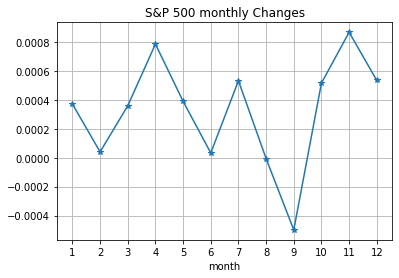

In [ ]:
df2.groupby('month')['log'].mean().plot(marker='*')
plt.grid(True)
plt.xticks(np.arange(1,13,1))
plt.title('S&P 500 monthly Changes')
plt.show()

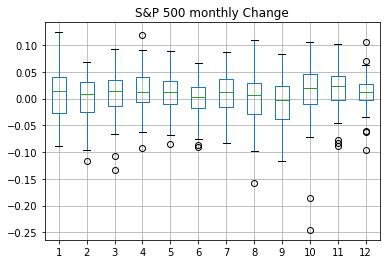

In [ ]:
tb2.boxplot()
plt.title('S&P 500 monthly Change')
plt.show()

In [ ]:
tb2[5].loc[tb2[5] < -0.05]

year
1984   -0.061171
2010   -0.085532
2012   -0.064699
2019   -0.068041
Name: 5, dtype: float64